In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from model import MNISTDiffusion
from utils import ExponentialMovingAverage
import os
import math
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.version())

2.0.0+cu117
True
11.7
8900


In [3]:
use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
batch_size = 128
epochs = 100
lr = 0.001
n_samples = 100
model_base_dim = 64
model_ema_steps = 10
model_ema_decay = 0.995
log_freq = 10
no_clip = True
timesteps = 1000

cuda


In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

100%|██████████| 9912422/9912422 [00:00<00:00, 212728772.23it/s]

Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 47042987.89it/s]


Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 67311220.95it/s]


Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8425709.32it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../data/MNIST/raw



In [5]:
model = MNISTDiffusion(timesteps=timesteps,
            image_size=28,
            in_channels=1,
            base_dim=model_base_dim,
            dim_mults=[2,4]).to(device)

In [6]:
#torchvision ema setting
#https://github.com/pytorch/vision/blob/main/references/classification/train.py#L317
adjust = 1 * batch_size * model_ema_steps / epochs
alpha = 1.0 - model_ema_decay
alpha = min(1.0, alpha * adjust)
model_ema = ExponentialMovingAverage(model, device=device, decay=1.0 - alpha)

In [7]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = OneCycleLR(optimizer, lr, total_steps=epochs*len(train_loader), pct_start=0.25, anneal_strategy='cos')
loss_fn = nn.MSELoss(reduction='mean')

# Train

In [11]:
global_steps=0
for i in range(epochs):
    model.train()
    for j, (image,target) in enumerate(train_loader):
        noise=torch.randn_like(image).to(device)
        image=image.to(device)
        pred=model(image,noise)
        loss=loss_fn(pred,noise)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        
        if global_steps % model_ema_steps==0:
            model_ema.update_parameters(model)
            
        global_steps+=1
        if j % log_freq==0:
            print("Epoch[{}/{}],Step[{}/{}],loss:{:.5f},lr:{:.5f}".format(i+1,epochs,j,len(train_loader),
                                                                loss.detach().cpu().item(), scheduler.get_last_lr()[0]))
    ckpt={"model":model.state_dict(),
            "model_ema":model_ema.state_dict()}

Epoch[1/100],Step[0/469],loss:0.02620,lr:0.00004
Epoch[1/100],Step[10/469],loss:0.02495,lr:0.00004
Epoch[1/100],Step[20/469],loss:0.02389,lr:0.00004
Epoch[1/100],Step[30/469],loss:0.02516,lr:0.00004
Epoch[1/100],Step[40/469],loss:0.02294,lr:0.00004
Epoch[1/100],Step[50/469],loss:0.02498,lr:0.00004
Epoch[1/100],Step[60/469],loss:0.02322,lr:0.00004
Epoch[1/100],Step[70/469],loss:0.02426,lr:0.00004
Epoch[1/100],Step[80/469],loss:0.02344,lr:0.00004
Epoch[1/100],Step[90/469],loss:0.02598,lr:0.00004
Epoch[1/100],Step[100/469],loss:0.02835,lr:0.00004
Epoch[1/100],Step[110/469],loss:0.02647,lr:0.00004
Epoch[1/100],Step[120/469],loss:0.02495,lr:0.00004
Epoch[1/100],Step[130/469],loss:0.02544,lr:0.00004
Epoch[1/100],Step[140/469],loss:0.02712,lr:0.00004
Epoch[1/100],Step[150/469],loss:0.02528,lr:0.00004
Epoch[1/100],Step[160/469],loss:0.02749,lr:0.00004
Epoch[1/100],Step[170/469],loss:0.02437,lr:0.00004
Epoch[1/100],Step[180/469],loss:0.02064,lr:0.00004
Epoch[1/100],Step[190/469],loss:0.02240,lr

# Reconstruct

In [23]:
torch.save(model.state_dict(), './model2.torch')
torch.save(model_ema.state_dict(), './model_ema2.torch')

In [8]:
model.load_state_dict(torch.load('./model.torch'))
model_ema.load_state_dict(torch.load('./model_ema.torch'))

<All keys matched successfully>

In [9]:
model_ema.eval()

ExponentialMovingAverage(
  (module): MNISTDiffusion(
    (model): Unet(
      (init_conv): ConvBnSiLu(
        (module): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
      )
      (time_embedding): Embedding(1000, 256)
      (encoder_blocks): ModuleList(
        (0): EncoderBlock(
          (conv0): Sequential(
            (0): ResidualBottleneck(
              (branch1): Sequential(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ConvBnSiLu(
                  (module): Sequential(
                    (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
                    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, 

In [10]:
samples = model_ema.module.sampling(n_samples, clipped_reverse_diffusion=not no_clip, device=device)

Sampling: 100%|██████████| 1000/1000 [01:00<00:00, 16.49it/s]


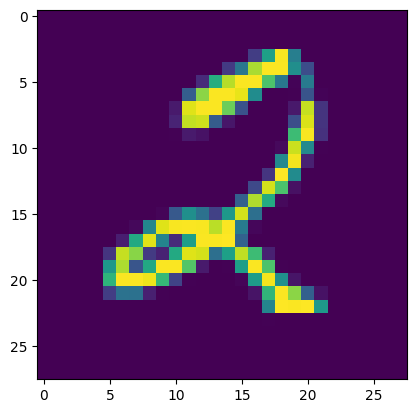

In [11]:
import matplotlib.pyplot as plt
plt.imshow(samples[0,0].detach().cpu().numpy())

In [28]:
save_image(samples,"results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(n_samples)))

# Test Noise+Reconstruction

In [55]:
batch0 = next(iter(test_loader))[0].to(device)
noise = torch.randn_like(batch0).to(device)
pred_noise = model_ema(batch0, noise)

In [50]:
def reconstruct(model, x_t, noise, batch_size, clipped_reverse_diffusion=True, device="cuda"):        
    for i in tqdm(range(timesteps-1, -1, -1), desc="Reconstruct"):
        t = torch.tensor([i for _ in range(batch_size)]).to(device)

        if clipped_reverse_diffusion:
            x_t = model._reverse_diffusion_with_clip(x_t, t, noise)
        else:
            x_t = model._reverse_diffusion(x_t, t, noise)

    x_t=(x_t+1.)/2. #[-1,1] to [0,1]

    return x_t

recon_pred = reconstruct(model_ema.module, pred_noise, noise, batch_size, clipped_reverse_diffusion=not no_clip, device=device)

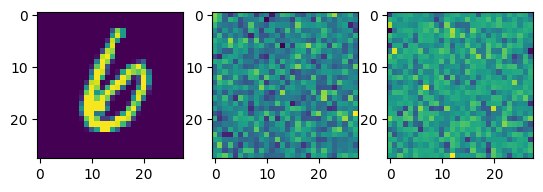

In [57]:
fig, axs = plt.subplots(1, 3)

axs[0].imshow(batch0.detach().cpu().numpy()[1,0])
axs[1].imshow(pred_noise.detach().cpu().numpy()[0,0])
axs[2].imshow(recon_pred.detach().cpu().numpy()[1,0])